In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [93]:
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.simplefilter("ignore")

## DBSCAN (PCA)

In [94]:
PCA_ds = pd.read_csv('data_reduccion_PCA.csv',sep=',')
PCA_ds.head()

,col1,col2,col3,col4,col5,col6
0,4.933287,-0.268851,0.297444,3.261175,-0.538835,0.372328
1,-2.935435,0.018579,-0.456699,-1.251371,-0.694831,1.940288
2,2.367150,-0.741681,-1.206743,-0.012712,-0.409824,-0.388788
3,-2.716321,-1.461183,-0.055200,-0.433844,1.155659,-0.284942
4,-0.795007,0.152362,-0.739367,-0.057153,1.258259,-1.264634


In [95]:
data = pd.read_csv('data_transformada_escalada.csv',sep=',')
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


### eps (epsilon)
Es el radio máximo de vecindad que define qué tan cerca deben estar dos puntos para considerarse "vecinos". Es decir, dos puntos están conectados si la distancia entre ellos es menor o igual a eps.

Un valor pequeño de eps significa que los puntos deben estar muy cerca para ser considerados vecinos. Esto puede resultar en:
- Más clusters pequeños.
- Más puntos clasificados como ruido (outliers).

Un valor grande de eps permite que los puntos estén más dispersos y aún así sean parte del mismo cluster. Esto puede resultar en:
- Menos clusters, pero más grandes.
- Menos puntos clasificados como ruido.

Para identificar un valor adecuado para epsilon, es común usar un gráfico de distancias k-ésimas más cercanas. Este gráfico muestra la distancia al vecino más cercano para cada punto y puede ayudar a identificar un "codo" donde aumentar eps deja de mejorar significativamente la densidad.

### min_samples
Es el número mínimo de puntos requeridos dentro del radio eps para que un punto sea considerado un punto central.
#### Tipos de puntos en DBSCAN :
- Punto central (core point) : Un punto que tiene al menos min_samples puntos dentro de su vecindad (eps).
- Punto frontera (border point) : Un punto que no es un punto central, pero está dentro de la vecindad de un punto central.
- Ruido (noise point) : Un punto que no es ni un punto central ni un punto frontera.

Un valor pequeño de min_samples (por ejemplo, 2 o 3) hace que sea más fácil formar clusters, incluso en regiones poco densas. Esto puede resultar en:
- Más clusters pequeños.
- Menos puntos clasificados como ruido.

Un valor grande de min_samples (por ejemplo, 5 o más) requiere mayor densidad para formar clusters. Esto puede resultar en:
- Menos clusters, pero más densos.
- Más puntos clasificados como ruido.

Un buen punto de partida para elegir su valor es duplicando la dimensionalidad del dataset (2 x dim)

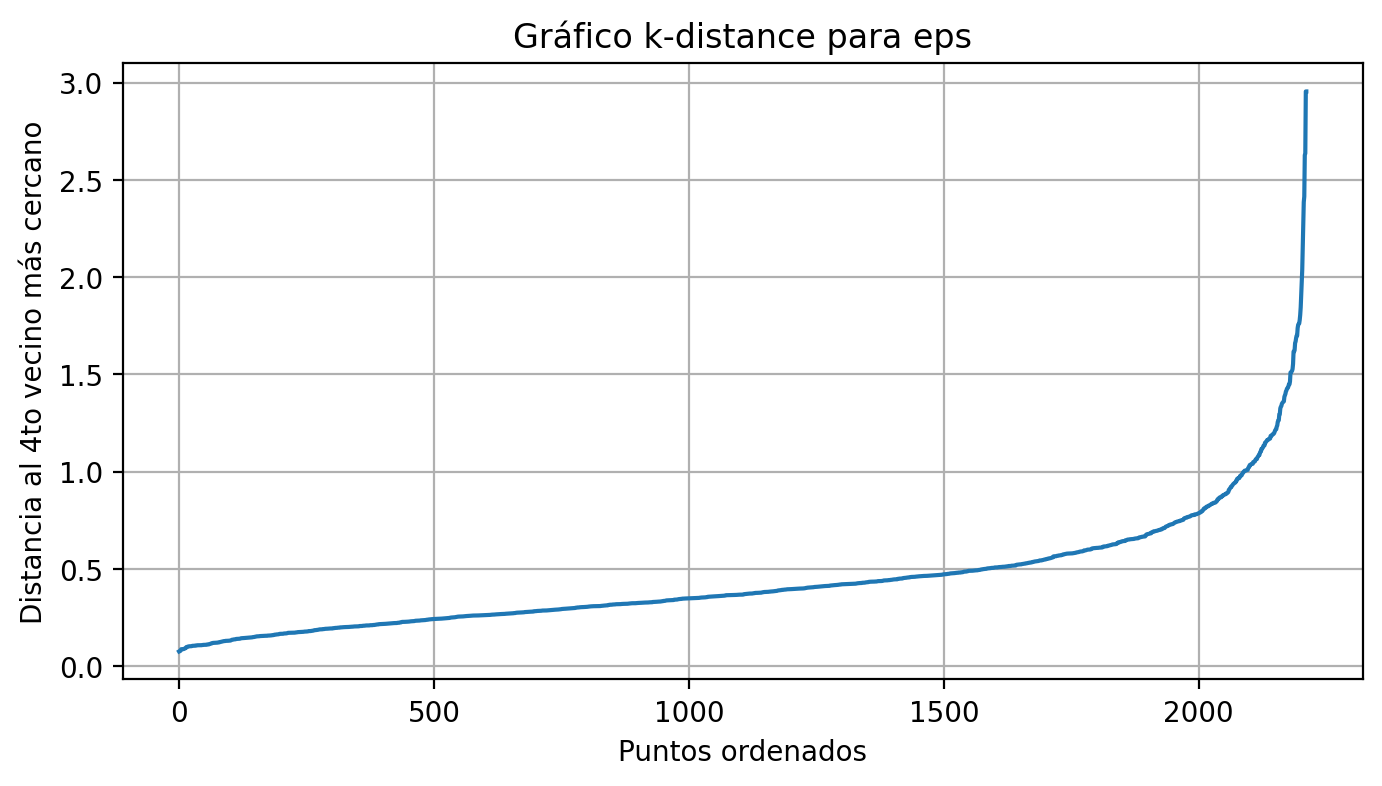

In [96]:
PCA_ds = PCA_ds.iloc[:,:3]
vecinos = NearestNeighbors(n_neighbors=5)
vecinos_ajuste = vecinos.fit(PCA_ds)
distancias, _ = vecinos_ajuste.kneighbors(PCA_ds)

distancias = np.sort(distancias[:, 4])  
plt.figure(figsize=(8, 4))
plt.plot(distancias)
plt.title("Gráfico k-distance para eps")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 4to vecino más cercano")
plt.grid(True)
plt.show()

In [98]:
dbscan = DBSCAN(eps=2.5, min_samples=5)
etiquetas_db = dbscan.fit_predict(PCA_ds)

mask = etiquetas_db != -1
labels_filtrados = etiquetas_db[mask]
if len(set(labels_filtrados)) > 1:
    score = silhouette_score(PCA_ds[mask], labels_filtrados)
    print(f"Silhouette Score (sin outliers): {score:.2f}")
else:
    print("No hay suficientes clusters para calcular silhouette score.")
    
score = silhouette_score(PCA_ds, etiquetas_db)
print(f"Silhouette Score DBSCAN (con outliers): {score:.2f}")
dbi_dbscan = davies_bouldin_score(PCA_ds, etiquetas_db)
print(f"Davies-Bouldin Index - DBSCAN: {dbi_dbscan}")
PCA_ds['Cluster'] = etiquetas_db
data['Cluster'] = etiquetas_db

No hay suficientes clusters para calcular silhouette score.
Silhouette Score DBSCAN (con outliers): 0.53
Davies-Bouldin Index - DBSCAN: 0.35020564252916003


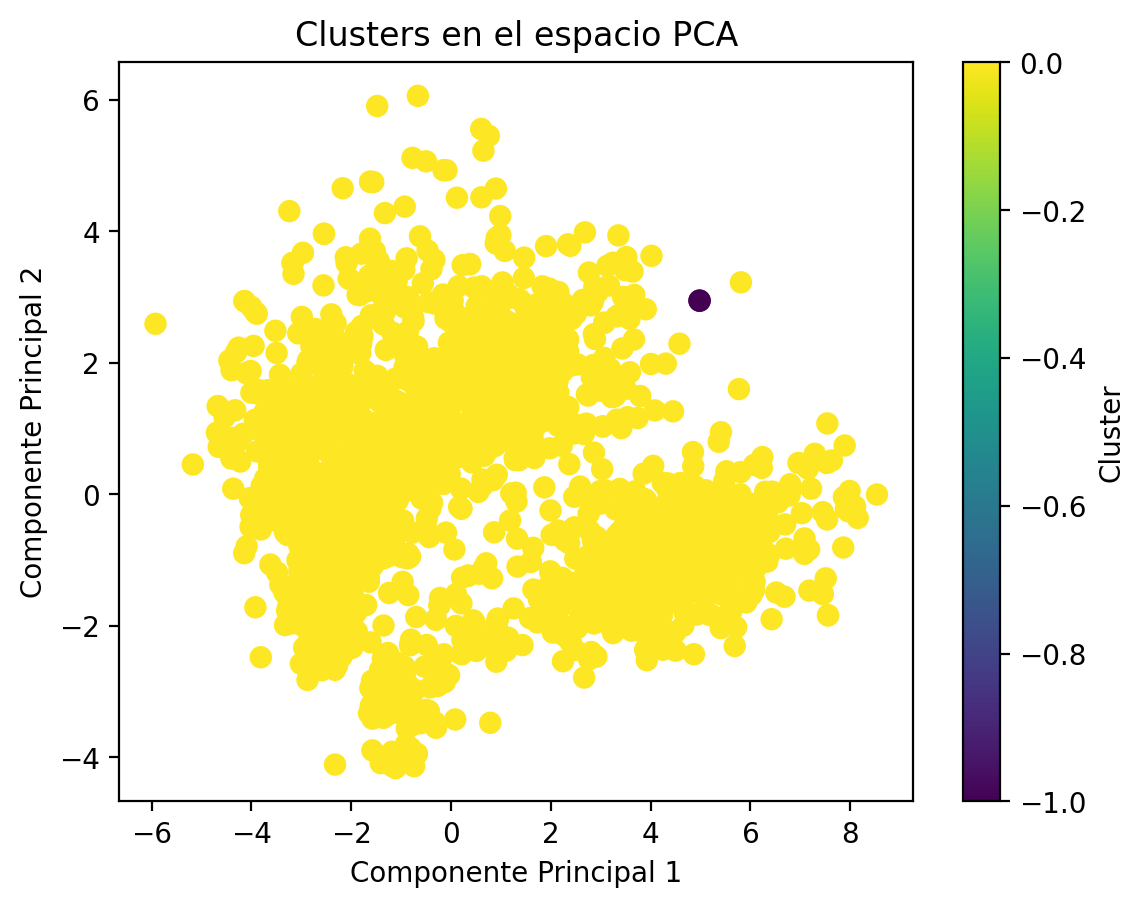

In [99]:
x = PCA_ds.iloc[:, 0] 
y = PCA_ds.iloc[:, 1]  

plt.scatter(x, y, c=dbscan.labels_, cmap='viridis', s=50)
plt.title('Clusters en el espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

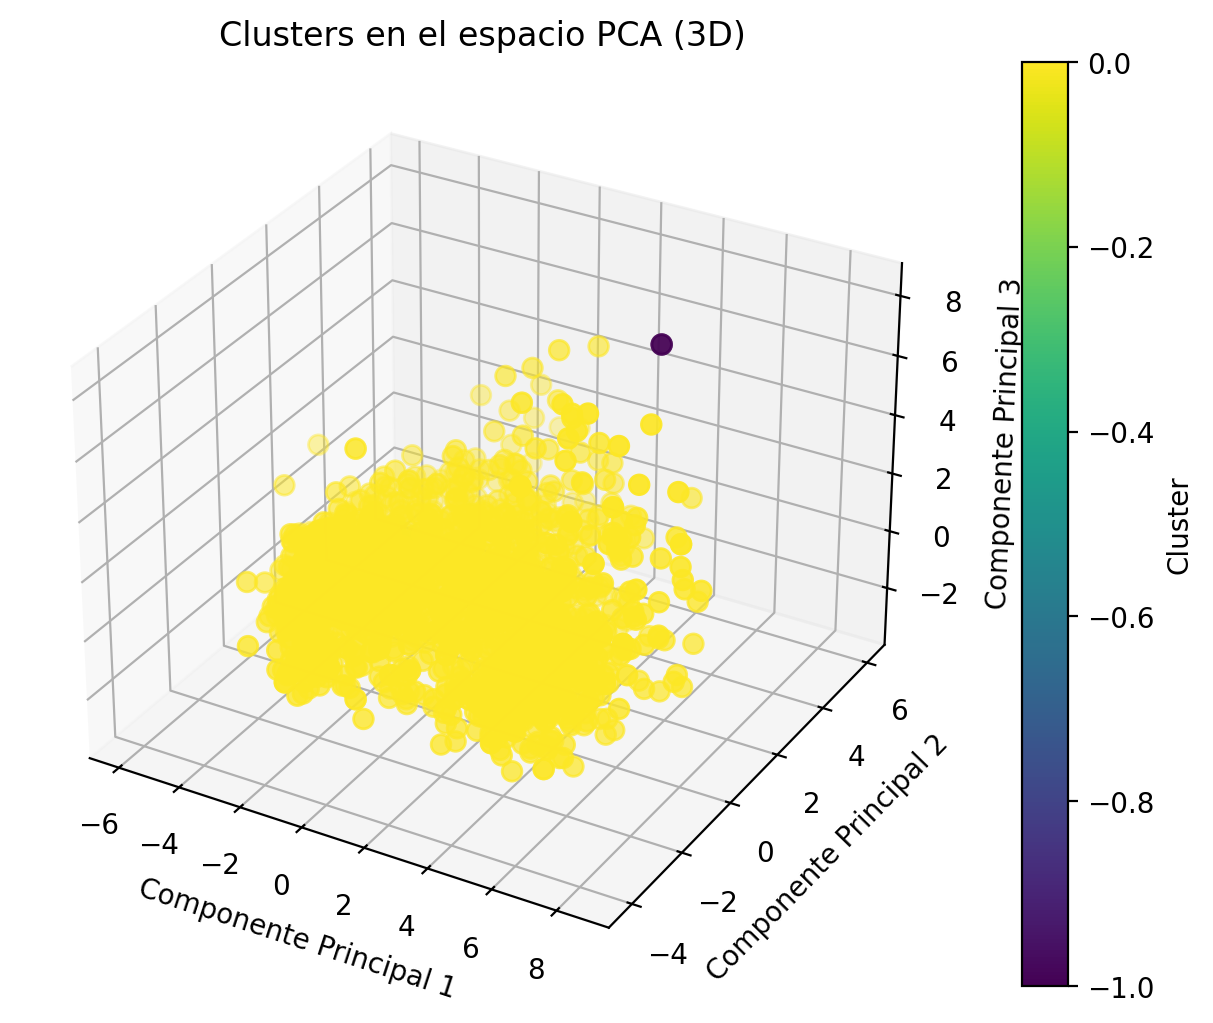

In [100]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

x = PCA_ds.iloc[:, 0]  
y = PCA_ds.iloc[:, 1]  
z = PCA_ds.iloc[:, 2]  

scatter = ax.scatter(x, y, z, c=dbscan.labels_, cmap='viridis', s=50)
plt.title('Clusters en el espacio PCA (3D)')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.colorbar(scatter, label='Cluster')
plt.show()

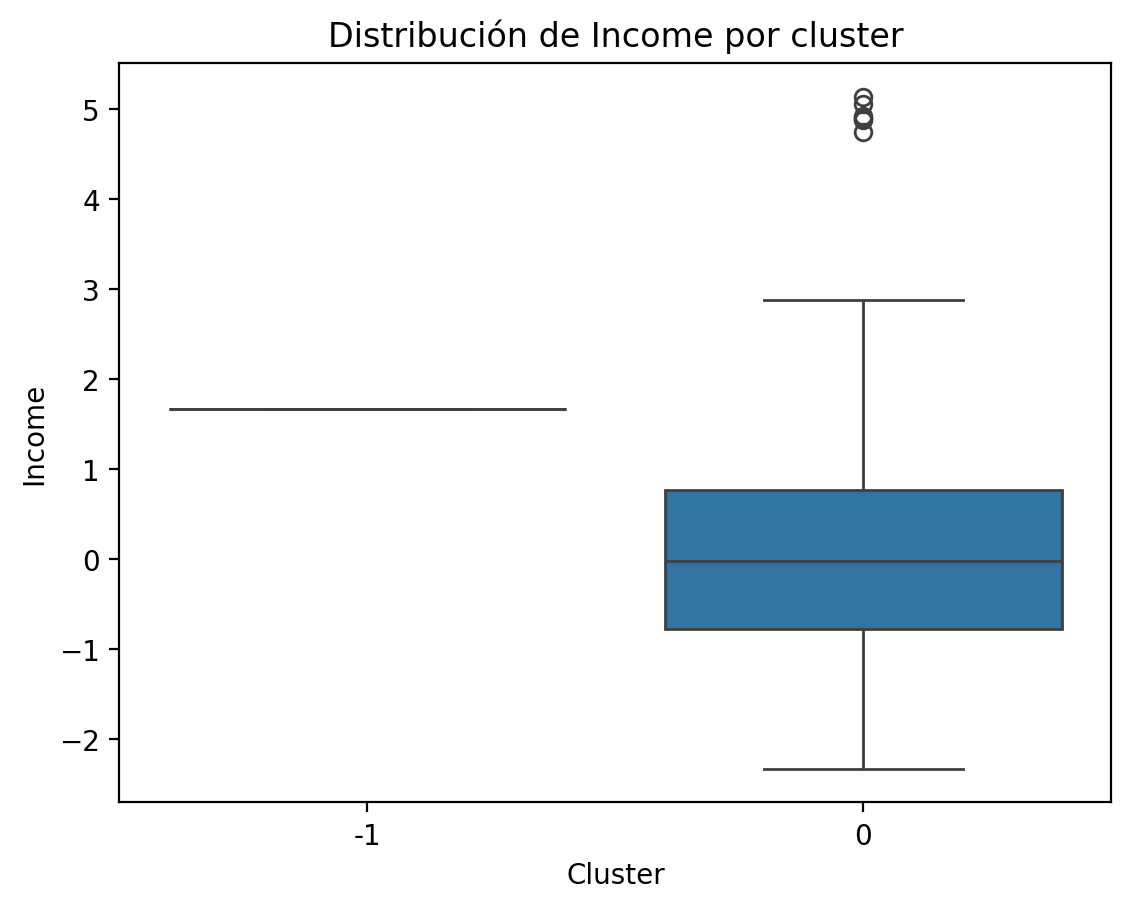

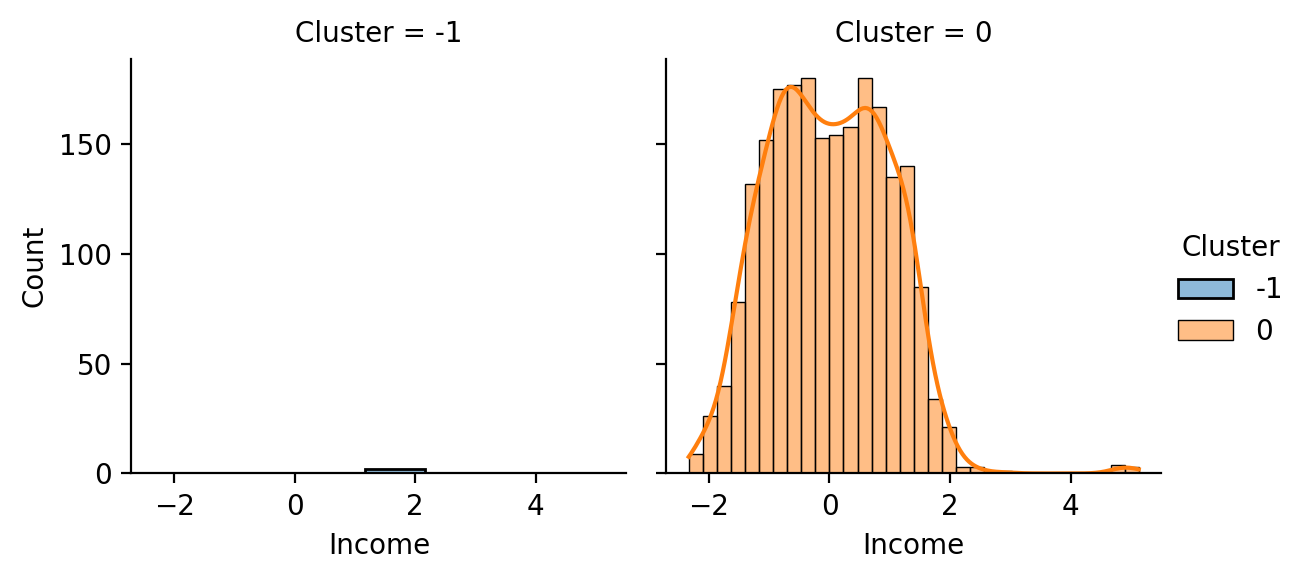

In [101]:
sns.boxplot(x='Cluster', y='Income', data=data)
plt.title('Distribución de Income por cluster')
plt.show()

g = sns.FacetGrid(data, col="Cluster", hue="Cluster", sharex=True, sharey=True)
g.map(sns.histplot, "Income", kde=True).add_legend()
plt.show()

## DBSCAN (TSNE)

In [127]:
TSNE_ds = pd.read_csv('data_reduccion_TSNE.csv',sep=',')
TSNE_ds.head()

,col1,col2
0,30.620274,-7.712108
1,-48.222248,12.715313
2,28.431597,-21.590351
3,-50.654060,-22.825716
4,-36.348347,-20.864601


In [128]:
data = pd.read_csv('data_transformada_escalada.csv',sep=',')
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


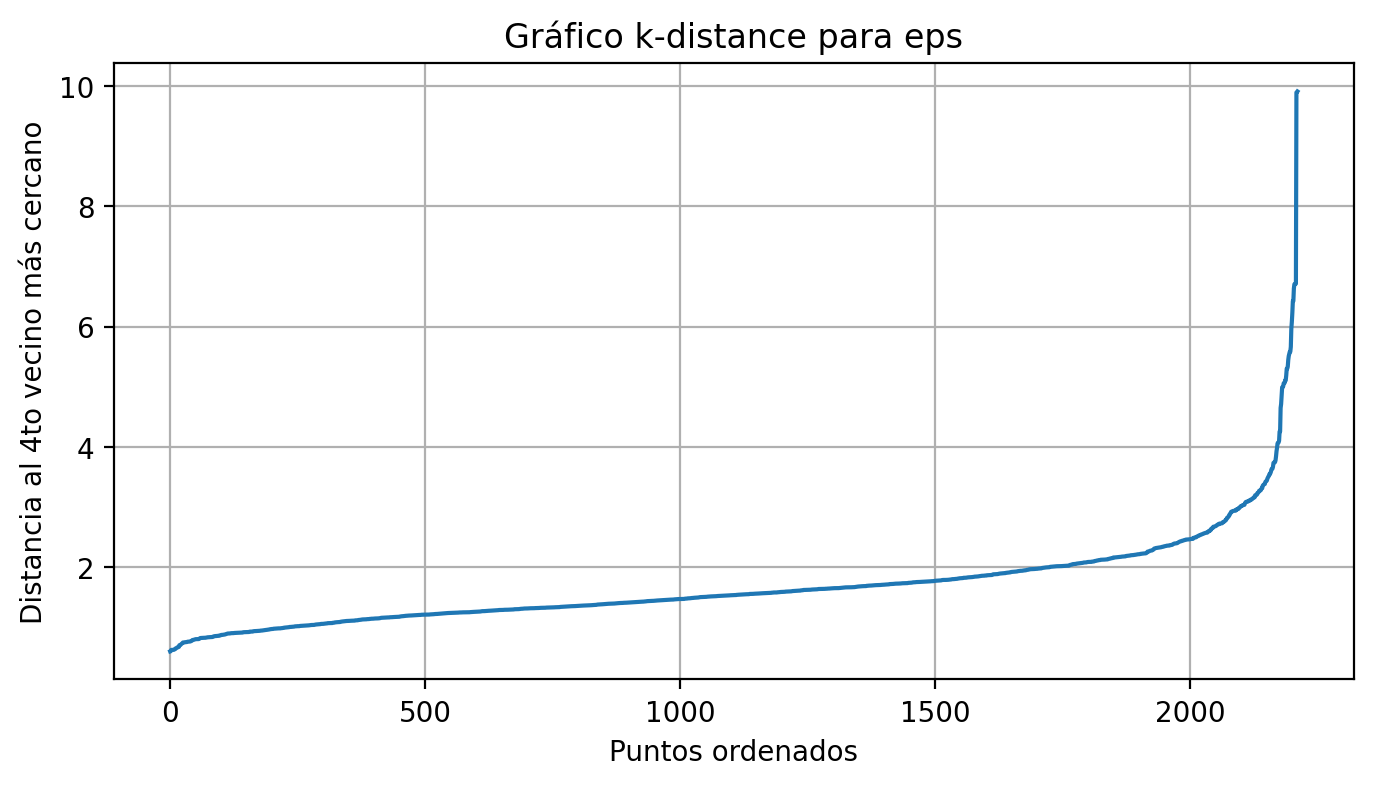

In [129]:
vecinos = NearestNeighbors(n_neighbors=5)
vecinos_ajuste = vecinos.fit(TSNE_ds)
distancias, _ = vecinos_ajuste.kneighbors(TSNE_ds)

distancias = np.sort(distancias[:, 4])  
plt.figure(figsize=(8, 4))
plt.plot(distancias)
plt.title("Gráfico k-distance para eps")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 4to vecino más cercano")
plt.grid(True)
plt.show()

In [141]:
dbscan = DBSCAN(eps=0.9, min_samples=5)
etiquetas_db = dbscan.fit_predict(TSNE_ds)

mask = etiquetas_db != -1
labels_filtrados = etiquetas_db[mask]
if len(set(labels_filtrados)) > 1:
    score = silhouette_score(TSNE_ds[mask], labels_filtrados)
    print(f"Silhouette Score (sin outliers): {score:.2f}")
else:
    print("No hay suficientes clusters para calcular silhouette score.")
    
score = silhouette_score(TSNE_ds, etiquetas_db)
print(f"Silhouette Score DBSCAN: {score:.2f}")
dbi_dbscan = davies_bouldin_score(TSNE_ds, etiquetas_db)
print(f"Davies-Bouldin Index - DBSCAN: {dbi_dbscan}")
TSNE_ds['Cluster'] = etiquetas_db
data['Cluster'] = etiquetas_db

Silhouette Score (sin outliers): 0.93
Silhouette Score DBSCAN: -0.46
Davies-Bouldin Index - DBSCAN: 0.8591482285950744


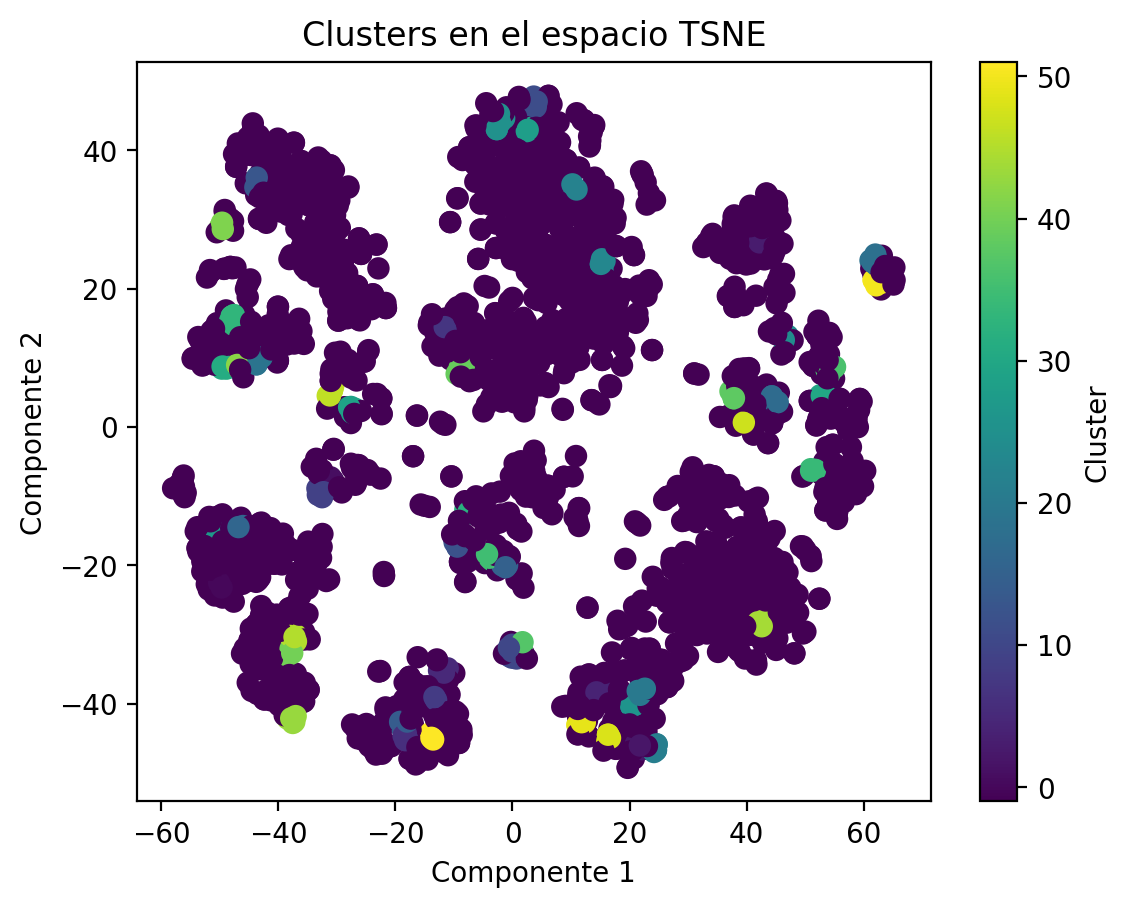

In [143]:
x = TSNE_ds.iloc[:, 0] 
y = TSNE_ds.iloc[:, 1]  

plt.scatter(x, y, c=dbscan.labels_, cmap='viridis', s=50)
plt.title('Clusters en el espacio TSNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

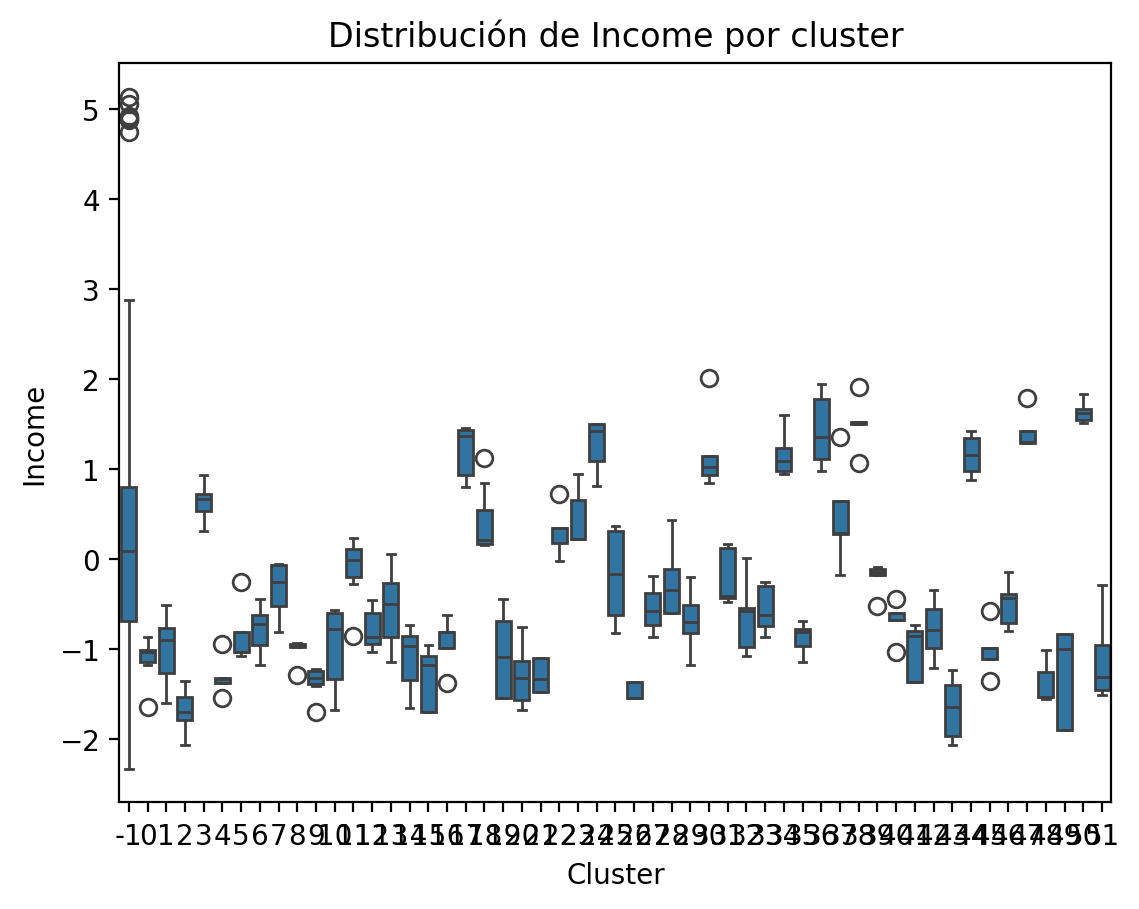

In [144]:
sns.boxplot(x='Cluster', y='Income', data=data)
plt.title('Distribución de Income por cluster')
plt.show()

g = sns.FacetGrid(data, col="Cluster", hue="Cluster", sharex=True, sharey=True)
g.map(sns.histplot, "Income", kde=True).add_legend()
plt.show()

## DBSCAN (UMAP)

In [145]:
UMAP_ds = pd.read_csv('data_reduccion_UMAP.csv',sep=',')
UMAP_ds.head()

,col1,col2
0,7.947662,12.219968
1,11.329375,-0.086987
2,5.836195,12.522989
3,6.380645,-6.642157
4,8.008347,-6.492001


In [146]:
data = pd.read_csv('data_transformada_escalada.csv',sep=',')
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


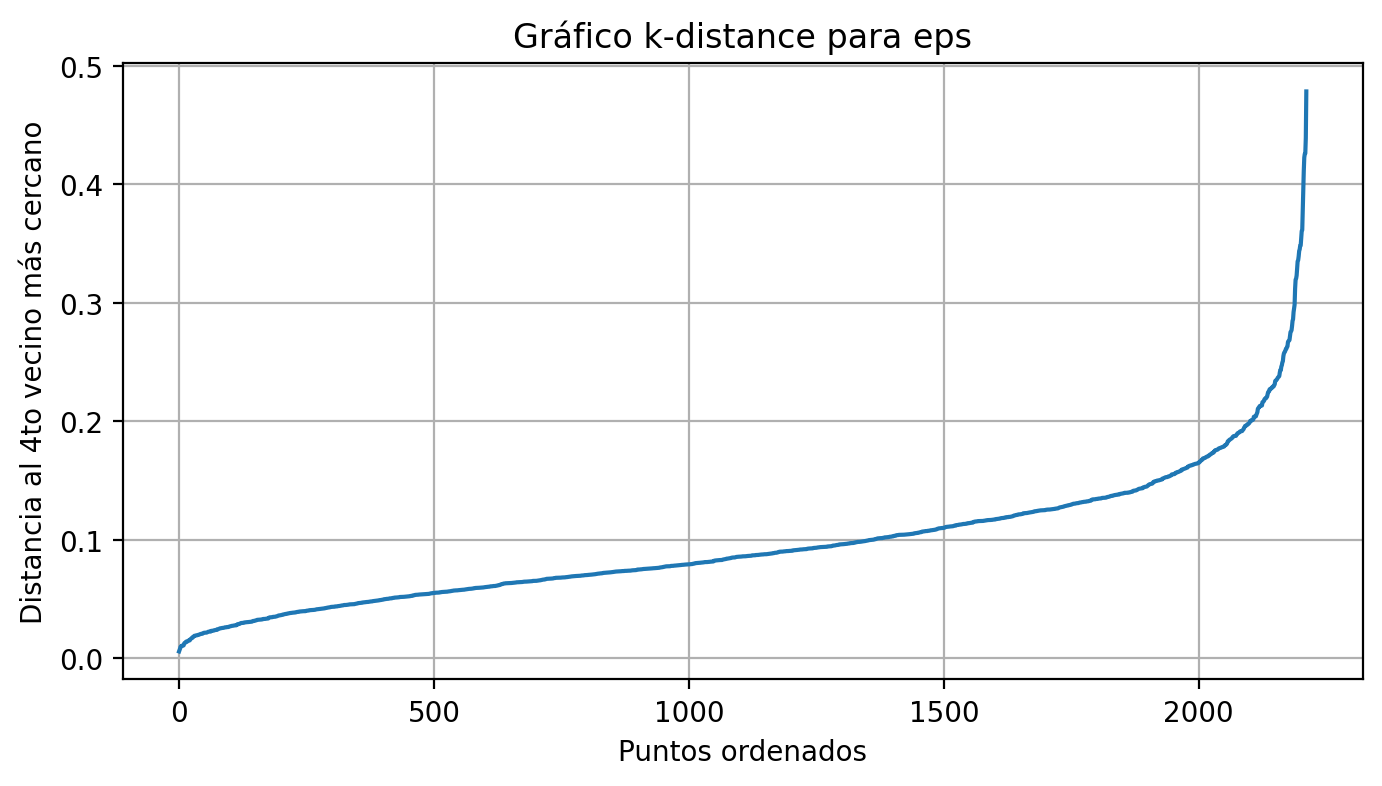

In [147]:
vecinos = NearestNeighbors(n_neighbors=5)
vecinos_ajuste = vecinos.fit(UMAP_ds)
distancias, _ = vecinos_ajuste.kneighbors(UMAP_ds)

distancias = np.sort(distancias[:, 4])  
plt.figure(figsize=(8, 4))
plt.plot(distancias)
plt.title("Gráfico k-distance para eps")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 4to vecino más cercano")
plt.grid(True)
plt.show()

In [155]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
etiquetas_db = dbscan.fit_predict(UMAP_ds)

mask = etiquetas_db != -1
labels_filtrados = etiquetas_db[mask]
if len(set(labels_filtrados)) > 1:
    score = silhouette_score(UMAP_ds[mask], labels_filtrados)
    print(f"Silhouette Score (sin outliers): {score:.2f}")
else:
    print("No hay suficientes clusters para calcular silhouette score.")
    
score = silhouette_score(UMAP_ds, etiquetas_db)
print(f"Silhouette Score DBSCAN: {score:.2f}")
dbi_dbscan = davies_bouldin_score(UMAP_ds, etiquetas_db)
print(f"Davies-Bouldin Index - DBSCAN: {dbi_dbscan}")
UMAP_ds['Cluster'] = etiquetas_db
data['Cluster'] = etiquetas_db

Silhouette Score (sin outliers): 0.82
Silhouette Score DBSCAN: 0.81
Davies-Bouldin Index - DBSCAN: 0.5084649956579459


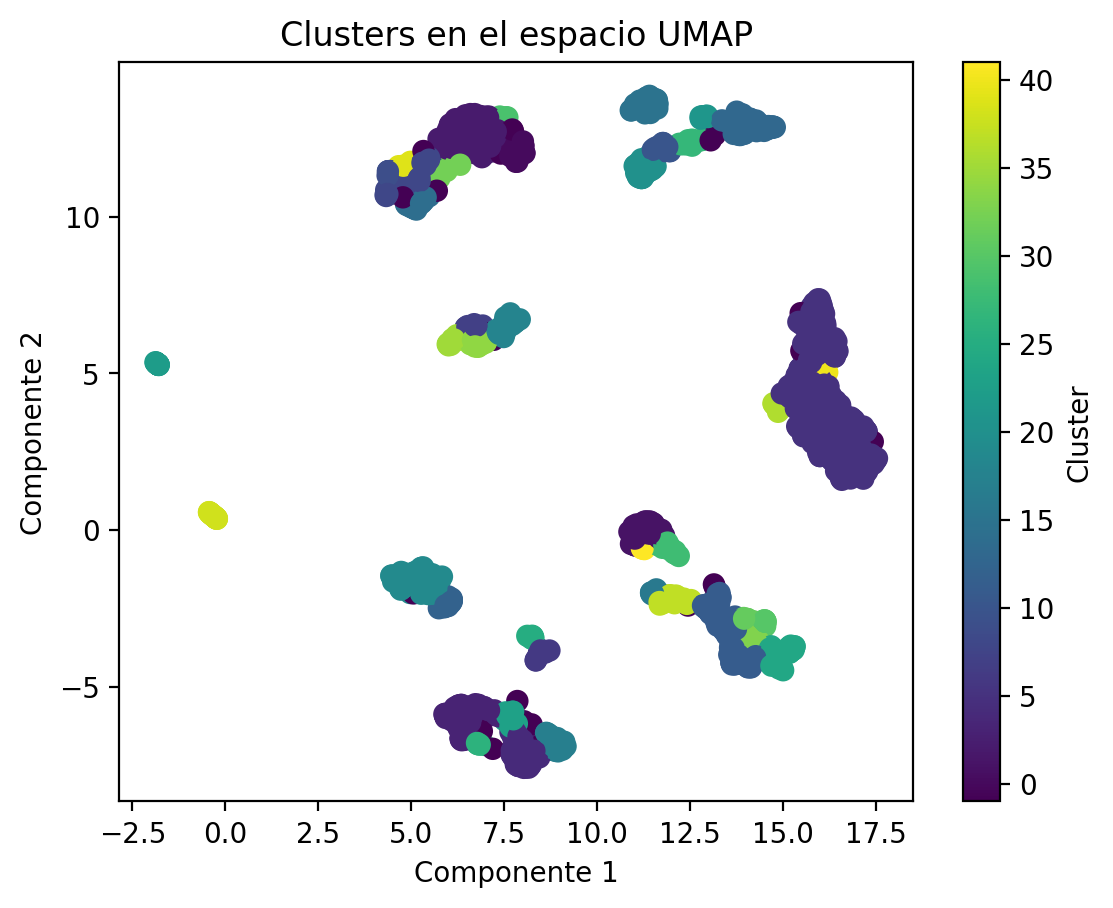

In [156]:
x = UMAP_ds.iloc[:, 0] 
y = UMAP_ds.iloc[:, 1]  

plt.scatter(x, y, c=dbscan.labels_, cmap='viridis', s=50)
plt.title('Clusters en el espacio UMAP')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

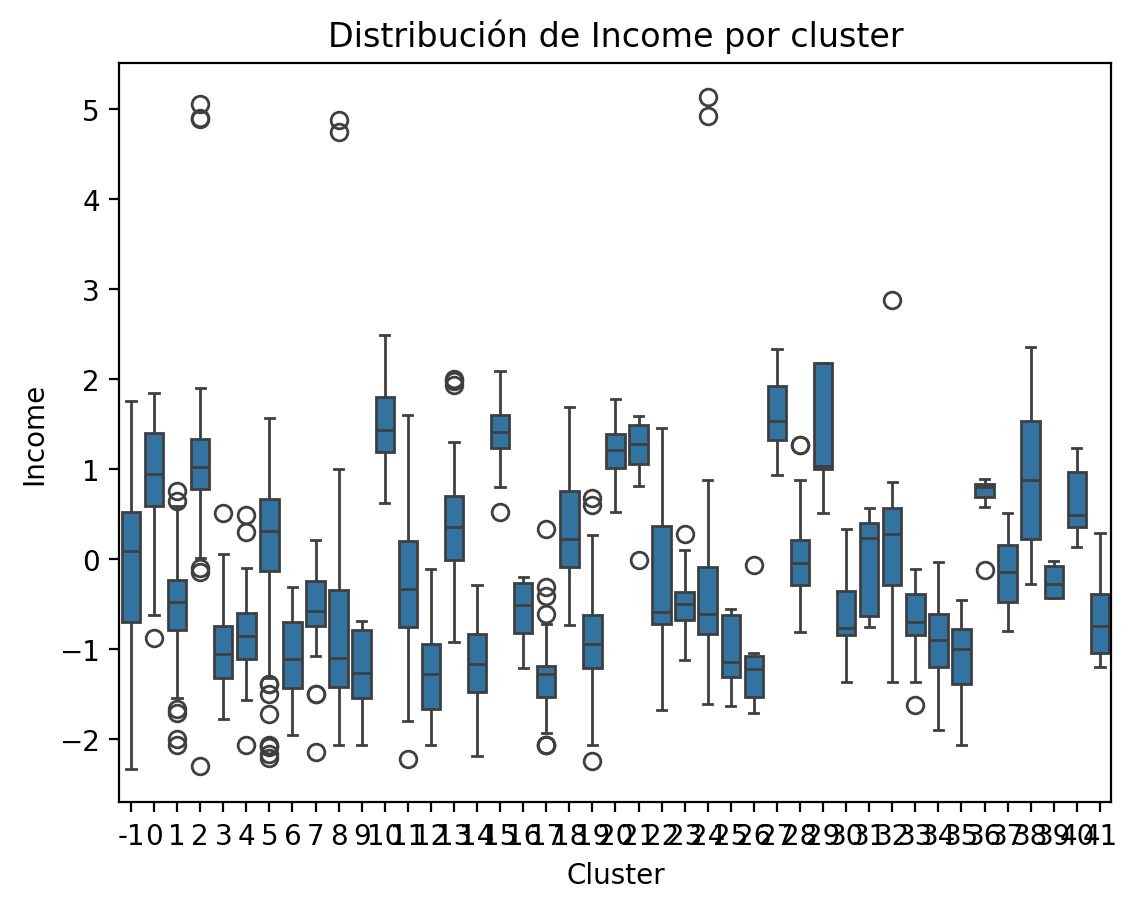

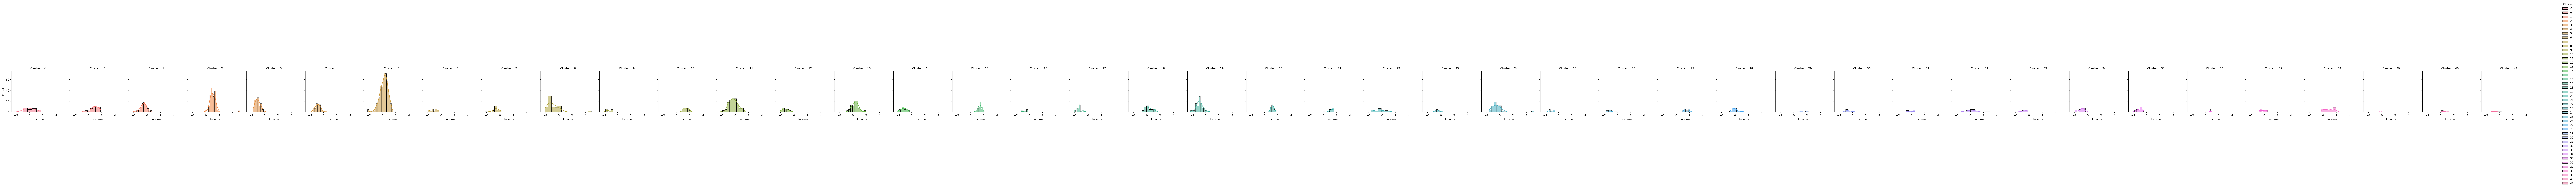

In [157]:
sns.boxplot(x='Cluster', y='Income', data=data)
plt.title('Distribución de Income por cluster')
plt.show()

g = sns.FacetGrid(data, col="Cluster", hue="Cluster", sharex=True, sharey=True)
g.map(sns.histplot, "Income", kde=True).add_legend()
plt.show()